In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import csv
import re
from collections import defaultdict

In [114]:
# This will make the nested defaultdict picklable.  
def nested_dict(n, type):
    """
    Creates a nested defaultdict with n levels.

    Parameters:
    n (int): The number of nested levels for the defaultdict.
    type: The default data type for the defaultdict.

    Returns:
    defaultdict: A nested defaultdict with n levels.
    """
    def create_nested_dict(n, type):
        # A helper function that creates a nested defaultdict with n levels
        if n == 1:
            return defaultdict(type)
        else:
            return defaultdict(lambda: create_nested_dict(n-1, type))

    return create_nested_dict(n, type)

def drop_duplicates_except_metric(results,cols,rows):
    # Remove duplicates
    n_rows_before = len(results.index)
    cols_subset = [i for i in results.columns if i != 'test_task_mrr']
    results = results.drop_duplicates(subset=[cols,rows], keep='first')
    n_rows_after = len(results.index)
    print('n_rows_before',n_rows_before, 'n_rows_after', n_rows_after) if n_rows_before != n_rows_after else None
    return results

def string2list(df):
    for column in df:
        try:
            # For all the colum, apply eval() to convert the string to a list
            if column != 'kge':
                df[column] = [np.array(eval(i)) for i in df[column].values]
        except:
            # print("Couldnt convert ", column)
            continue

    # for each col that is a string or int or object, print the unique values 
    print('\nUnique values:')
    for col in df.columns:
        try: 
            if df[col].dtype == 'object' or df[col].dtype == 'int64' or df[col].dtype == 'string':
                print(col,df[col].unique())
        except:
            continue
    return df

def split_df(df):
    # create a df that is the same as the original but with the first value of the colums in the list metrics
    df_mean = df.copy()
    df_std = df.copy()
    for col in df_mean.columns:
        try:
            # df_mean[col] = [i[0] for i in df_mean[col].values]
            vals = []
            # print('col',col, 'df_mean[col].values',df_mean[col].values)
            for i in df_mean[col].values:
                if i is not np.nan:
                    vals.append(i[0])
                else:
                    vals.append(i)
            # substitute the values of the col with the new values
            df_mean[col] = vals
        except:
            continue
    # Do the same for the std
    for col in df_std.columns:
        try:
            # df_std[col] = [i[1] for i in df_std[col].values]
            vals = []
            for i in df_std[col].values:
                if i is not np.nan:
                    vals.append(i[1])
                else:
                    vals.append(i)
            # substitute the values of the col with the new values
            df_std[col] = vals
        except:
            continue
    return df_mean, df_std

In [115]:
# tasks = ['countries_s1','countries_s2','countries_s3']
# names_files = ['_countries']
tasks = ['ablation_d1','ablation_d2','ablation_d3']
names_files = ['_ablation']
current_dir = os.getcwd()
root = current_dir + "/plots/experiments/"
for i,file in enumerate(names_files):
    path = root + "experiments"  + file + ".csv"
    dfi = pd.read_csv(path, sep=';', keep_default_na=False, skiprows=0, skip_blank_lines=True, comment='\n')
    dfi = dfi.drop_duplicates()
    if i == 0:
        df = dfi
    else:
        df = pd.concat([df, dfi], ignore_index=True)
df = df.drop_duplicates()
df = string2list(df)
# to avoid problems with the None from Rule miner
df['rule_miner'] = df['rule_miner'].apply(lambda x: 'No' if str(x) == 'None' else x)


Unique values:
dataset_name ['ablation_d1' 'ablation_d2' 'ablation_d3']
grounder ['backward_0_1' 'backward_1_1' 'backward_1_2' 'backward_1_3'
 'backward_2_1' 'backward_2_2' 'backward_2_3']
kge ['complex']
model_name ['dcr' 'sbr' 'no_reasoner' 'r2n']
kge_atom_embedding_size [100]
batch_size [256]
val_batch_size [256]
test_batch_size [256]
facts_file ['facts.txt']
train_file ['train.txt']
valid_file ['valid.txt']
test_file ['test.txt']
domain_file ['domain2constants.txt']
rules_file ['rules.txt']
corrupt_mode ['TAIL']
num_negatives [1]
valid_negatives [100]
format ['functional']
engine_num_negatives [0]
engine_num_adaptive_constants [0]
constant_embedding_size [200]
predicate_embedding_size [200]
lr_sched ['plateau']
optimizer ['adam']
epochs [100]
num_rules [1 0]
loss ['binary_crossentropy']
cdcr_num_formulas [3]
valid_frequency [1]
r2n_prediction_type ['nofull' 'head']
reasoner_depth [1]
reasoner_formula_hidden_embedding_size [100]
reasoner_atom_embedding_size [100]
filter_num_heads [

In [116]:
cols = 'grounder'
rows = 'model_name'
step = 'test'
metrics = [step+'_task_mrr', 'time_train','time_inference']
KGEs = ['complex'] #, 'distmult', 'transe']
KGEs_name = {'complex':'ComplEx'} #, 'distmult':'DistMult', 'transe':'TransE'}
baseline_model = 'no_reasoner'
baseline_metric = step + '_concept_mrr'
# select the rows from df where the column models has the values ['dcr','mno_reasoner'] 
models = ['sbr','dcr','r2n','no_reasoner'] # ,'gsbr','cdcr'
models_no_baseline = [i for i in models if i != baseline_model]
df = df.loc[df['model_name'].isin(models)]
rule_miners = ['No', 'amie'] 
grounders = ['backward_1_1','backward_1_2','backward_1_3','backward_2_1','backward_2_2','backward_2_3','backward_3_1','backward_3_2','domainbody','full','relationentity'] 

models_name = {'sbr':'SBR', 'rnm':'RNM', 'dcr':'DCR', 'r2n':'R2N', 'no_reasoner':'Baseline'} #, 'gsbr':'GSBR', 'cdcr':'CDCR'
# models_name = {'r2n': 'Relational Reasoning Networks [3]' ,'sbr':'Semantic Based Regularization [2]', 'rnm':'Relational Neural Machines', 'dcr':'Deep Concept Reasoner [4]', 'r2n':'Relational Reasoning Networks[3]', 'no_reasoner':'Baseline'} #, 'gsbr':'GSBR', 'cdcr':'CDCR'
ground_name = {'relationentity':'Entity Rel.','backward_1':'Backward 1', 'backward_2':'Backward 2', 'backward_3':'Backward 3', 'full':'Full', 'domainbody':'Full', 
                'backward_prune_1':'Back. prune 1', 'backward_prune_2':'Back. prune 2', 'backward_prune_3':'Back. prune 3'}
metric_names = {step+'_task_mrr':'MRR', 'time':'Time (s)', 'time_train':'Train Time (s)', 'time_inference':'Inference Time (s)','test_task_hits@1@1':'Hits@1', 'test_task_hits@3@3':'Hits@3', 'test_task_hits@10@10':'Hits@10'}
dataset_names = {'countries_s2': 'Countries S2', 'countries_s3': 'Countries S3', 'countries_s1': 'Countries S1', 'nations': 'Nations', 
                 'kinship_family_small': 'Kinship Family Small', 'kinship_family': 'Kinship', 'pharmkg_supersmall': 'PharmKG Supersmall',
                  'kinship_family_reason_2': 'Kinship Family reason (2)', 'wn18rr': 'WN18RR','FB15k237': 'FB15k237',
                  'pharmkg_small': 'PharmKG small', 'pharmkg_full': 'PharmKG','pharmkg_small_reason_2': 'PharmKG small Reason',
                  'ablation_d1': 'Ablation D1', 'ablation_d2': 'Ablation D2', 'ablation_d3': 'Ablation D3'}
model_colors = {'sbr':'#1f77b4', 'rnm':'#ff7f0e', 'dcr':'#2ca02c', 'r2n':'#d62728', 'no_reasoner':'#9467bd'} #, 'gsbr':'#8c564b', 'cdcr':'#e377c2'

# Prepare data

In [117]:
rows = 'grounder'
# cols = ['test_task_mrr', 'test_task_hits@1@1','test_task_hits@3@3', 'test_task_hits@10@10','time_train','time_inference']
cols = ['test_task_mrr', 'test_task_hits@1','test_task_hits@3', 'test_task_hits@10','time_train','time_inference']
cols_baseline = [i.replace('task','concept') for i in cols]
models_results = []
best_results = nested_dict(3, dict)
for task in tasks:
    df_table = None
    for KGE in KGEs:
        for rule_miner in rule_miners:                # verify that the rule miner is within the values of Rule_Miner, else continue
            miners_available = df.loc[ (df['dataset_name'] == task) &(df['kge'] == KGE)]['rule_miner'].apply(lambda x: str(x)).unique()
            if (rule_miner not in miners_available):
                continue
            print('\nTask',task,'KGE: ', KGE, ' Rule miner: ', rule_miner)
            
            # Get the results, filter and sort them
            results = df.loc[(df['dataset_name'] == task) &(df['kge'] == KGE) &(df['rule_miner'] == rule_miner) & df['grounder'].isin(grounders)].copy() 
            results = results[['dataset_name','model_name',rows]+cols]
            results = results.sort_values(by=['dataset_name', 'model_name', 'grounder'])
            print('\nresults',results) 

            # get the results of the baseline (using concept instead of task)
            baseline = df.loc[(df['model_name'] == 'no_reasoner') & (df['dataset_name'] == task) &(df['kge'] == KGE) &(df['rule_miner'] == rule_miner)]
            baseline = baseline[['dataset_name','model_name',rows]+cols_baseline]
            assert len(baseline) <= 1, 'There is more than one baseline'
            # Substitute the model_name=='no_reasoner' by 'Baseline', and grounder by '-'
            baseline['model_name'] = 'Baseline'
            baseline['grounder'] = '-'
            print(baseline)

            # Remove all the rows that contain a 'no_reasoner' in the model_name
            results = results[results['model_name'] != 'no_reasoner']
            results = results.reset_index(drop=True)
            # append the baseline to the results
            if len(baseline) > 0:
                list_to_append  =  list(baseline.values)[0]
                print('\nlist_to_append',list_to_append)
                results.loc[len(results)] = list_to_append

            # for the colums ['test_task_mrr', 'test_task_hits@1@1','test_task_hits@3@3', 'test_task_hits@10@10'], get the best result, which is in the first element of the list of each cell
            # for col in ['test_task_mrr', 'test_task_hits@1@1','test_task_hits@3@3', 'test_task_hits@10@10']:
            for col in ['test_task_mrr', 'test_task_hits@1','test_task_hits@3', 'test_task_hits@10']:
                # best_results[task][col] = results[col].apply(lambda x: x[0] if type(x) is np.ndarray else x).max()
                results_ = results[col].apply(lambda x: x[0] if type(x) is np.ndarray else x)
                best_results[task][col]  =  results_[results_.apply(lambda x: type(x) is not str)].max()
                # print('\nbest_results',col,best_results[model][task][col])
            results = results.reset_index(drop=True)
            print('\nresults',results) 
            if df_table is None:
                df_table = results
                print(' df table assigned')
            else:
                df_table = pd.concat([df_table, results], ignore_index=True)
                print('cocnattt')
    # add the model to the list
    models_results.append(df_table) if df_table is not None else None



Task ablation_d1 KGE:  complex  Rule miner:  No

results    dataset_name   model_name      grounder   test_task_mrr test_task_hits@1  \
3   ablation_d1          dcr  backward_1_1  [0.971, 0.002]      [0.96, 0.0]   
5   ablation_d1          dcr  backward_1_2  [0.998, 0.004]   [0.996, 0.008]   
7   ablation_d1          dcr  backward_1_3  [0.998, 0.004]   [0.996, 0.008]   
9   ablation_d1          dcr  backward_2_1  [0.971, 0.002]      [0.96, 0.0]   
11  ablation_d1          dcr  backward_2_2  [0.998, 0.004]   [0.996, 0.008]   
13  ablation_d1          dcr  backward_2_3  [0.998, 0.004]   [0.996, 0.008]   
2   ablation_d1  no_reasoner  backward_1_1  [0.997, 0.005]   [0.996, 0.008]   
45  ablation_d1          r2n  backward_1_1  [0.986, 0.002]      [0.98, 0.0]   
46  ablation_d1          r2n  backward_1_2  [0.994, 0.005]    [0.988, 0.01]   
47  ablation_d1          r2n  backward_1_3  [0.994, 0.008]    [0.992, 0.01]   
4   ablation_d1          sbr  backward_1_1  [0.971, 0.002]      [0.96, 0.

# Tables overleaf

In [ ]:
def bold_best_result_col(x, best_results, task, col):
    if type(x) is np.ndarray:
        mean_original,var_original = x
        
        if 'time' in col:
            mean = round(mean_original,1)
            return str(mean) 

        else:
            mean,var = round(100*mean_original,1),round(100*var_original,1)
        # print('mean_original',mean_original, task,col,best_results[model][task][col])
            if mean_original == best_results[task][col]:
                if task in ['pharmkg_full','wn18rr', 'FB15k237' ]:
                    return '\\textbf{'+str(mean)+'}'
                else: 
                    return '\\textbf{'+str(mean)+'}±'+str(var)
            else:
                if task in ['pharmkg_full','wn18rr', 'FB15k237' ]:
                    return str(mean)
                else:
                    return str(mean)+'±'+str(var)
    else:
        return x
    

for i,df_table in enumerate(models_results):
    # convert the content of every cell in cols from '[n1,n2]' to str(n1)+'+'+str(n2) if the content is not a string
    for col in cols:
        # df_table[col] = df_table[col].apply(lambda x: str(x[0])+'±'+str(x[1]) if type(x) is np.ndarray else x)
        df_table[col] = df_table.apply(lambda x: bold_best_result_col(x[col], best_results, x['dataset_name'], col), axis=1)
    

    # substitute the names of the colums by the proper names. For column, if its name is in metric_names, substitute it by the value of the dictionary
    list_cols = ['Dataset','Model', 'Grounder'] + [metric_names[i] if i in metric_names.keys() else i for i in cols]
    df_table.columns = list_cols

    # in df_table, subtitute in the column Dataset the names of the datasets by the proper names, and do the same for the grounders
    df_table['Dataset'] = df_table['Dataset'].apply(lambda x: dataset_names[x])
    df_table['Model'] = df_table['Model'].apply(lambda x: models_name[x] if x in models_name.keys() else x)
    df_table['Grounder'] = df_table['Grounder'].apply(lambda x: ground_name[x] if x in ground_name.keys() else x)
    df_table = df_table.reset_index(drop=True)

In [ ]:
df_table_final = pd.concat(models_results, ignore_index=True)
#round the cols Train Time (s)	Inference Time (s)
df_table_final['Train Time (s)'] = df_table_final['Train Time (s)'].apply(lambda x: str(round(x,1)))
df_table_final['Inference Time (s)'] = df_table_final['Inference Time (s)'].apply(lambda x: str(round(x,1)))
# show the full df in the print
pd.set_option('display.max_rows', None) 
df_table_final

,Dataset,Model,Grounder,MRR,test_task_hits@1,test_task_hits@3,test_task_hits@10,Train Time (s),Inference Time (s)
0,Countries S1,DCR,backward_1_1,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,30.1,0.1
1,Countries S1,DCR,backward_1_2,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,30.9,0.1
2,Countries S1,DCR,backward_1_3,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,30.2,0.1
3,Countries S1,DCR,backward_2_1,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,29.9,0.1
4,Countries S1,DCR,backward_2_2,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,30.2,0.1
5,Countries S1,DCR,backward_2_3,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,30.1,0.1
6,Countries S1,R2N,backward_1_1,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,25.4,0.1
7,Countries S1,R2N,backward_1_2,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,25.4,0.1
8,Countries S1,R2N,backward_1_3,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,25.2,0.1
9,Countries S1,R2N,backward_2_1,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,\textbf{100.0}±0.0,25.1,0.1


In [ ]:
latex_df = df_table_final.to_latex(index=False)
print(latex_df)

\begin{tabular}{lllllllll}
\toprule
Dataset & Model & Grounder & MRR & test_task_hits@1 & test_task_hits@3 & test_task_hits@10 & Train Time (s) & Inference Time (s) \\
\midrule
Countries S1 & DCR & backward_1_1 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & 30.1 & 0.1 \\
Countries S1 & DCR & backward_1_2 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & 30.9 & 0.1 \\
Countries S1 & DCR & backward_1_3 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & 30.2 & 0.1 \\
Countries S1 & DCR & backward_2_1 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & 29.9 & 0.1 \\
Countries S1 & DCR & backward_2_2 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & 30.2 & 0.1 \\
Countries S1 & DCR & backward_2_3 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & \textbf{100.0}±0.0 & 30.1 & 0.1 \\
Countries S1 & R2N 

# PLOT IJCAI 25

In [118]:
for i,model_results in enumerate(models_results):
    # filter the rows that contain Baseline in the grounder
    models_results[i] = model_results[model_results['grounder'] != 'Baseline']
    models_results[i] = model_results[model_results['model_name'] != 'Baseline']


In [119]:
import matplotlib.font_manager as fm

font_path = os.path.join(current_dir+'/plots/Times_New_Roman', 'times_new_roman.ttf')  # Replace 'times.ttf' with the actual file name

try:
    fm.fontManager.addfont(font_path)
    prop = fm.FontProperties(fname=font_path)
    font_name = prop.get_name()
    plt.rcParams["font.family"] = font_name
except FileNotFoundError:
    print(f"Font file not found at {font_path}. Using default font.")
    plt.rcParams["font.family"] = "serif" # or another default font
except Exception as e:
    print(f"Error loading font: {e}. Using default font.")
    plt.rcParams["font.family"] = "serif" # or another default font

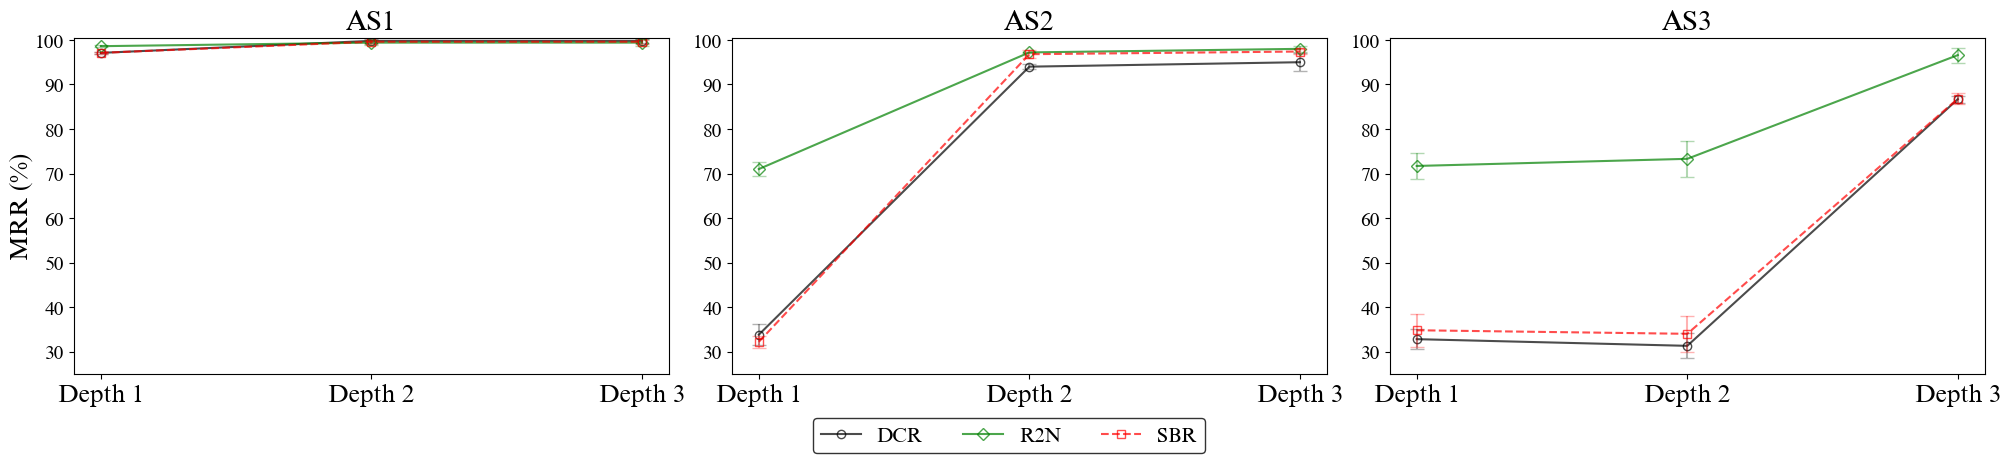

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sample Data (Replace with your actual data)
np.random.seed(42)  # for reproducibility
model_colors = {'dcr': 'black', 'r2n': 'green', 'sbr': 'red'}
model_markers = {'dcr': 'o', 'r2n': 'D', 'sbr': 's'}

fig, axes = plt.subplots(1, 3, figsize=(20, 4))  # 2x2 grid for 4 plots
axes = axes.flatten()  # flatten axes for easier indexing

# Adjust subplot parameters for tighter spacing
plt.subplots_adjust(wspace=0.2, hspace=0.01)  # Adjust these values as needed

plot_index = 0
for i, dataset in enumerate(models_results):
    for w_index, width in enumerate([1]):
        ax = axes[plot_index]  # select current subplot
        plot_index += 1
        for j, model in enumerate(['dcr', 'r2n', 'sbr']):
            plot_df = dataset.loc[(dataset['model_name'] == model) &
                                   (dataset['grounder'].str.contains(f'backward_{width}', case=False))].copy()
            ordered_list = [f'backward_{width}_{i}' for i in range(1, 4)]
            plot_df['grounder'] = pd.Categorical(plot_df['grounder'], categories=ordered_list, ordered=True)
            plot_df = plot_df.sort_values(by='grounder')
            # print('\n',i,'\n',plot_df)

            x_coords = np.arange(len(plot_df['grounder']))
            y_coords = plot_df['test_task_mrr'].apply(lambda x: x[0]) * 100
            y_err = plot_df['test_task_mrr'].apply(lambda x: x[1]) * 100

            ax.set_ylim(25, 100)

            color = model_colors[model]
            marker = model_markers[model]
            linestyle = '-'
            if model == 'sbr':
                linestyle = '--'

            ax.plot(x_coords, y_coords, linestyle=linestyle, alpha=0.7,
                    label=plot_df['model_name'].values[0], color=color, marker=marker, fillstyle='none')
            ax.errorbar(x_coords, y_coords, yerr=y_err, fmt='none', capsize=5, alpha=0.3, color=color)

            ax.tick_params(labelsize=14)  # Increase font size for all labels
            if plot_index in [1]:  # check if it is the first plot of the row
                ax.set_ylabel('MRR (%)', fontsize=18, rotation=90, labelpad=1)  # Increase font size, use Times New Roman

            ax.set_title(f'AS{i + 1}', fontsize=20)  # Increase font size, use Times New Roman

            grounders = ['Depth ' + str(i) for i in range(1, 4)]
            ax.set_xticks(np.arange(len(grounders)))
            ax.set_xticklabels(grounders, rotation=0, fontsize=18)  

            def ytick_format(value, tick_number):
                if value > 100:
                    return ''
                else:
                    return int(value)
            ax.yaxis.set_major_formatter(plt.FuncFormatter(ytick_format))
            ax.set_ylim(None,100.5)

            # ax.grid(True, linestyle='--', linewidth=0.4, color='gray', alpha=0.7, axis='y')
            ax.grid(False)

handles, labels = axes[0].get_legend_handles_labels()
new_labels = {'dcr': 'DCR', 'sbr': 'SBR', 'r2n': 'R2N'}
new_labels_list = [new_labels.get(label, label) for label in labels] # keep original label if not found.
by_label = dict(zip(new_labels_list, handles))  # Use new labels
fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, 0.0),
           ncol=3, fontsize='x-large', frameon=True, framealpha=0.8, edgecolor="black")

plt.tight_layout(pad=0.1)  # add padding
# plt.show()
# save it to current_dir/plots
plt.savefig(current_dir+'/plots/ablation_results.png', dpi=600, bbox_inches='tight')

In [105]:
# remove the row with Baselie and, for every model in the table, add a copy of it subtituting model_name by the model name
for i,model_results in enumerate(models_results):
    df_table = models_results[i].copy()
    baseline = df_table.loc[df_table['model_name'] == 'Baseline']
    # print(baseline)
    models = df_table['model_name'].unique()
    new_rows = []
    for model in models:
        if model == 'Baseline':
            continue
        # print('\nmodel',model)
        new_row = baseline.copy()
        new_row['model_name'] = model
        new_row['grounder'] = 'Baseline'
        # print('\nnew_row\n',new_row)
        new_rows.append(new_row)

    # overwrite  df_table to concat df_table with the new rows 
    # df_table = pd.concat([df_table] + new_rows, ignore_index=True)
    # df_table = df_table[df_table['model_name'] != 'Baseline']
    models_results[i] = pd.concat([df_table] + new_rows, ignore_index=True)


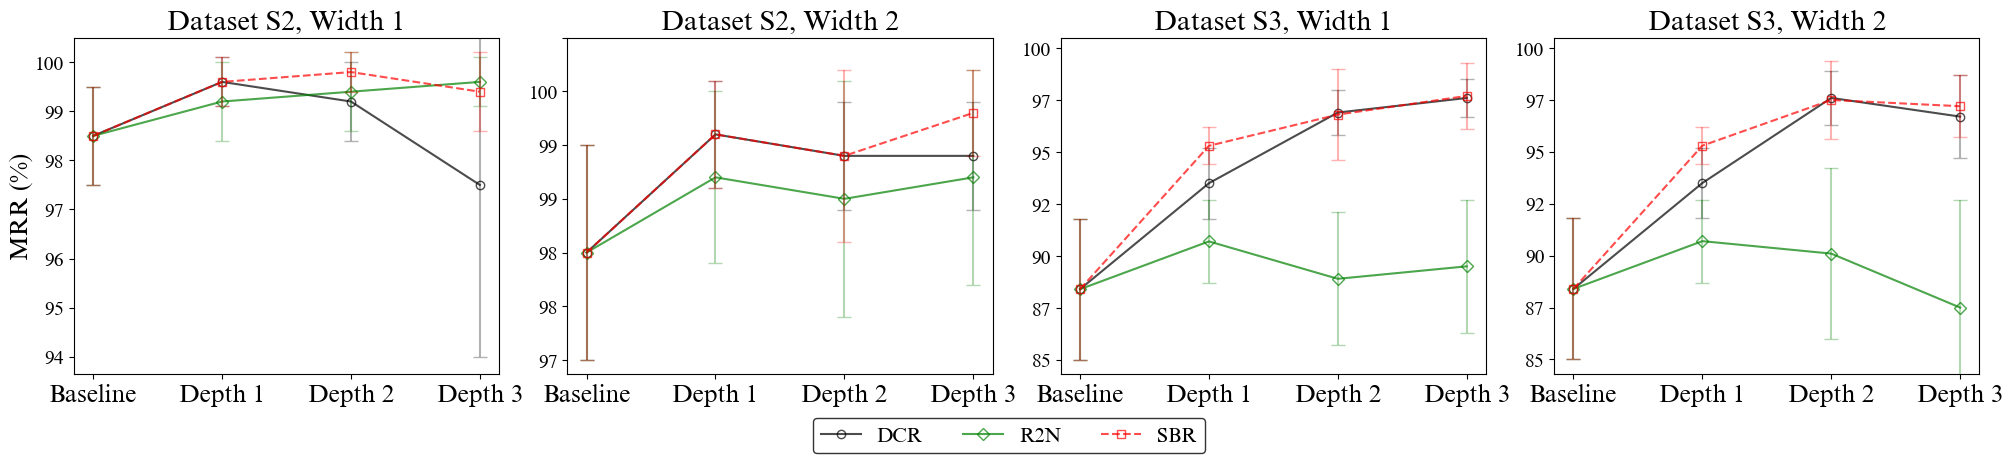

In [112]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sample Data (Replace with your actual data)
np.random.seed(42)  # for reproducibility
model_colors = {'dcr': 'black', 'r2n': 'green', 'sbr': 'red'}
model_markers = {'dcr': 'o', 'r2n': 'D', 'sbr': 's'}

fig, axes = plt.subplots(1, 4, figsize=(20, 4))  # 2x2 grid for 4 plots
axes = axes.flatten()  # flatten axes for easier indexing

# Adjust subplot parameters for tighter spacing
plt.subplots_adjust(wspace=0.2, hspace=0.01)  # Adjust these values as needed

plot_index = 0
for i, dataset in enumerate(models_results):
    if i == 0:
        continue
    for w_index, width in enumerate([1, 2]):
        ax = axes[plot_index]  # select current subplot
        plot_index += 1
        for j, model in enumerate(['dcr', 'r2n', 'sbr']):
            plot_df = dataset.loc[(dataset['model_name'] == model) &
                                   (dataset['grounder'].str.contains(f'backward_{width}', case=False) |
                                    dataset['grounder'].str.contains('Baseline', case=False)
                                    )].copy()
            ordered_list = ['Baseline'] + [f'Backward_{width}_{i}' for i in range(1, 4)]
            plot_df['grounder'] = pd.Categorical(plot_df['grounder'], categories=ordered_list, ordered=True)
            plot_df = plot_df.sort_values(by='grounder')

            x_coords = np.arange(len(plot_df['grounder']))
            y_coords = plot_df['test_task_mrr'].apply(lambda x: x[0]) * 100
            y_err = plot_df['test_task_mrr'].apply(lambda x: x[1]) * 100

            color = model_colors[model]
            marker = model_markers[model]
            linestyle = '-'
            if model == 'sbr':
                linestyle = '--'

            ax.plot(x_coords, y_coords, linestyle=linestyle, alpha=0.7,
                    label=plot_df['model_name'].values[0], color=color, marker=marker, fillstyle='none')
            ax.errorbar(x_coords, y_coords, yerr=y_err, fmt='none', capsize=5, alpha=0.3, color=color)

            ax.tick_params(labelsize=14)  # Increase font size for all labels
            if plot_index in [1]:  # check if it is the first plot of the row
                ax.set_ylabel('MRR (%)', fontsize=18, rotation=90, labelpad=1)  # Increase font size, use Times New Roman

            ax.set_title(f'Dataset S{i + 1}, Width {width}', fontsize=20)  # Increase font size, use Times New Roman

            grounders = ['Baseline'] + ['Depth ' + str(i) for i in range(1, 4)]
            ax.set_xticks(np.arange(len(grounders)))
            ax.set_xticklabels(grounders, rotation=0, fontsize=18)  

            def ytick_format(value, tick_number):
                if value > 100:
                    return ''
                else:
                    return int(value)
            ax.yaxis.set_major_formatter(plt.FuncFormatter(ytick_format))
            ax.set_ylim(None,100.5)

            # ax.grid(True, linestyle='--', linewidth=0.4, color='gray', alpha=0.7, axis='y')
            ax.grid(False)
            # if plot_index in [1]:
            #     handles, labels = ax.get_legend_handles_labels()
            #     by_label = dict(zip(labels, handles))
            #     ax.legend(by_label.values(), by_label.keys(),
            #             loc='lower left', fontsize='xx-large', frameon=True, framealpha=0.8, edgecolor="black", ncol=1)

handles, labels = axes[0].get_legend_handles_labels()
new_labels = {'dcr': 'DCR', 'sbr': 'SBR', 'r2n': 'R2N'}
new_labels_list = [new_labels.get(label, label) for label in labels] # keep original label if not found.
by_label = dict(zip(new_labels_list, handles))  # Use new labels
fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, 0.0),
           ncol=3, fontsize='x-large', frameon=True, framealpha=0.8, edgecolor="black")



plt.tight_layout(pad=0.1)  # add padding
# plt.show()
# save it to current_dir/plots
plt.savefig(current_dir+'/plots/countries_results.png', dpi=600, bbox_inches='tight')

# Models in x axis

One table for the different models with KGE complex (also for the other KGEs)
Another table for the different KGEs
Another table for the time with the best model and the best KGE

In [95]:
# Table 1: rows:grounder, cols:Model, values: mrr
csv_dir = "C:\\Users\\rodri\\Downloads\\PhD\\Review_grounders\\keras_ns_grounders\\experiments\\countries\\hparamsearch\\results.csv"
# create the dict dfs with 4 levels of keys: task, KGE, metric, rule_miner
dfs = nested_dict(4, dict)
for task in tasks:
    for metric in metrics:
        for KGE in KGEs:
            for rule_miner in rule_miners:
                print('KGE: ', KGE, ' Metric: ', metric, ' Task: ', task, ' Rule miner: ', rule_miner)
                # verify that the rule miner is within the values of Rule_Miner, else continue
                
                miners_available = df.loc[ (df['Task'] == task) &(df['KGE'] == KGE)]['Rule_Miner'].unique()
                if (rule_miner not in miners_available):
                    print('Not available: rule_miner',rule_miner,'. Available: ',miners_available)
                    continue
                # filter the df
                results = df.loc[ (df['Task'] == task) &(df['KGE'] == KGE) &(df['Rule_Miner'] == rule_miner) ].copy() #& (df['WeightLoss_Task'] == 0.5) & (df['Reasoner_depth'] == 1) & (df['EmbedSize'] == 100)].copy()
                # take only the columns grounder, model, test_task_mrr, test_concept_mrr
                results = results[[cols, rows, metric]]
                # Remove duplicates
                results = drop_duplicates_except_metric(results,cols,rows)
                # put the model_name as colums
                results = results.pivot(index=rows, columns=cols, values=metric)

                if metric == 'test_task_mrr':
                    # in the column no_reasoner, put the values of the column test_concept_mrr
                    substitute = df.loc[(df['Task'] == task) & (df['KGE'] == KGE) &(df['Rule_Miner'] == rule_miner) & (df['Model_name'] == baseline_model)][[cols,rows,baseline_metric]] #& (df['WeightLoss_Task'] == 0.5) & (df['Reasoner_depth'] == 1) & (df['EmbedSize'] == 100)][[cols,rows,baseline_metric]]
                    # drop the duplicates , based on all the colums except for 'test_task_mrr'
                    substitute = drop_duplicates_except_metric(substitute,cols,rows)
                    substitute = substitute.pivot(index=rows, columns=cols, values=baseline_metric)
                    # substitute the values in the table
                    # print('\n\nsubstitute',substitute)
                    # print('\n\nresults',results)
                    if len(substitute) > 0:
                        results.loc[baseline_model] = substitute.loc[baseline_model] 
                    # print('\n\nresults',results)
                
                # obtain one df for the mean and one for the std
                results_mean, results_std = split_df(results)
                # append the results to dfs
                dfs[task][KGE][metric][rule_miner]['mean'] = results_mean
                dfs[task][KGE][metric][rule_miner]['std'] = results_std
                print('\n\nresults_mean',results_mean)
                
                # with open(csv_dir, 'a') as f:
                #     f.write('\n Task : ,' + task + 'KGE : ,' + KGE + ', Metric: ,' + metric)
                #     f.write('\n ') 
                # results.to_csv(csv_dir, mode='a', header=True)  
print(task, KGE, metric, rule_miner)
results_mean

KGE:  complex  Metric:  test_task_mrr  Task:  ablation  Rule miner:  No


KeyError: 'Task'

In [293]:
# # for every df of dfs, create a new df with the average over the models
# dfs_avg = nested_dict(4, dict)
# for task in tasks:
#     for metric in metrics:
#         for KGE in KGEs:
#             for rule_miner in rule_miners:
#                 for types in ['mean', 'std']:
#                     print(types, 'KGE: ', KGE, ' Metric: ', metric, ' Task: ', task, ' Rule miner: ', rule_miner)
#                     if rule_miner not in dfs[task][KGE][metric].keys():
#                         continue
#                     dfi = dfs[task][KGE][metric][rule_miner][types].copy()
#                     # select from dfi the models that are in models_no_baseline
#                     dfi = dfi.loc[models_no_baseline]
#                     dfi = dfi.mean(axis=0)
#                     dfi = pd.DataFrame(dfi)
#                     # set the name of the column as the metric
#                     dfi.columns = [metric]
#                     dfs_avg[task][KGE][metric][rule_miner][types] = dfi
#                     # print(dfi)
# dfi

## PLOTS

In [2]:
# # Table 1: rows:grounder, cols:Model, values: mrr
# metric_names = {step+'_task_mrr':'MRR', 'Time':'Time (s)'}
# root_dir = "C:\\Users\\rodri\\Downloads\\PhD\\Review_grounders\\keras_ns_grounders\\experiments\\countries\\hparamsearch\\figures\\"
# os.makedirs(root_dir) if not os.path.exists(root_dir) else None
# for task in tasks:
#     for metric in ['test_task_mrr']:
#         for KGE in KGEs:
#             for rule_miner in rule_miners:
#                 print('KGE: ', KGE, ' Metric: ', metric, ' Task: ', task, ' Rule miner: ', rule_miner)
#                 if rule_miner not in dfs[task][KGE][metric].keys():
#                     continue
#                 df_mean = dfs[task][KGE][metric][rule_miner]['mean']
#                 df_std = dfs[task][KGE][metric][rule_miner]['std']
#                 print(df_mean)
#                 # Remove no reasoner and include a line where it is written baseline
#                 plt.figure(figsize=(10,5))
#                 for i,grounder in enumerate(df_mean.loc[models_no_baseline].columns):
#                     plt.scatter(np.arange(len(df_mean.loc[models_no_baseline].index))+0.1*i, df_mean.loc[models_no_baseline][grounder], label=grounder, alpha=0.5)
#                     plt.errorbar(np.arange(len(df_mean.loc[models_no_baseline].index))+0.1*i, df_mean.loc[models_no_baseline][grounder], yerr=df_std.loc[models_no_baseline][grounder], fmt='o',capsize=5, alpha=0.5)
#                 if metric == step+'_task_mrr':
#                     plt.axhline(y=df_mean.loc[baseline_model].mean(), color='black', linestyle='--', alpha=.7)  # Change color and linestyle as desired
#                     plt.text(1.8, df_mean.loc[baseline_model].mean()-0.005, 'Baseline', color='black', fontsize=12, ha='center')
#                     # print(df_mean.loc[baseline_model].values[0])
#                 plt.legend()
#                 plt.xticks(np.arange(len(df_mean.loc[models_no_baseline].index))+0.2, df_mean.loc[models_no_baseline].index.tolist(), rotation=0)
#                 plt.ylabel(metric_names[metric])
#                 plt.xlabel('Model')
#                 min = np.array([i for i in df_mean.loc[models].values.ravel() if i != np.nan])
#                 max = np.array([i for i in df_mean.loc[models].values.ravel() if i != np.nan])
#                 if min.min()<10:
#                     print(min.min)
#                     plt.ylim(min.min()-0.1,max.max()+0.13)
#                 plt.title(f'Grounders across models. Task: {task}, KGE: {KGE}, Set: {step}, Rule miner: {rule_miner}')
#                 plt.show()
#                 # SAVE THE FIGURE
#                 # if the directory does not exist, create it
#                 # plt.savefig(root_dir+'Grounders_across_models__'+'Task_'+task+'_Metric_'+metric+'_KGE_'+KGE+'_rule_'+rule_miner+'.png', dpi=300, bbox_inches='tight')  

In [251]:
# # Now do the plot of the average over the models
# for task in tasks:
#     for metric in ['test_task_mrr']:
#         for KGE in KGEs:
#             for rule_miner in ['None', 'amie', 'ncrl']:
#                 print('KGE: ', KGE, ' Metric: ', metric, ' Task: ', task, ' Rule miner: ', rule_miner)
#                 if rule_miner not in dfs[task][KGE][metric].keys():
#                     continue
#                 df_mean = dfs_avg[task][KGE][metric][rule_miner]['mean']
#                 print(df_mean)
#                 df_std = dfs_avg[task][KGE][metric][rule_miner]['std']
#                 # Remove no reasoner and include a line where it is written baseline
#                 plt.figure(figsize=(10,5))
#                 plt.scatter(np.arange(len(df_mean.index)),df_mean.values.flatten(), alpha=0.5)
#                 plt.errorbar(np.arange(len(df_mean.index)),df_mean.values.flatten(), yerr=df_std.values.flatten(), fmt='o',capsize=5, alpha=0.5)
#                 if metric == step+'_task_mrr':
#                     baseline = dfs[task][KGE][metric][rule_miner]['mean'].loc[baseline_model].mean()
#                     plt.axhline(y=baseline, color='black', linestyle='--', alpha=.7)   
#                     plt.text(1.8, baseline-0.005, 'Baseline', color='black', fontsize=12, ha='center')
#                 # in the xlabel put the names of the grounders
#                 plt.xticks(np.arange(len(df_mean.index)), df_mean.index.tolist(), rotation=0)
#                 plt.ylabel(metric_names[metric])
#                 min = np.array([i for i in df_mean.values.flatten() if i != np.nan])
#                 max = np.array([i for i in df_mean.values.flatten() if i != np.nan])
#                 print(min.min() is np.nan)
#                 if min.min()<1:
#                     print(min.min)
#                     plt.ylim(min.min()-0.1,max.max()+0.1)
#                 plt.title(f'Grounders across models. Task: {task}, KGE: {KGE}, Set: {step}, Rule miner: {rule_miner}')
#                 plt.show()
#                 # SAVE THE FIGURE
#                 # if the directory does not exist, create it
#                 # plt.savefig(root_dir+'Grounders_across_models__'+'Task_'+task+'_Metric_'+metric+'_KGE_'+KGE+'_rule_'+rule_miner+'.png', dpi=300, bbox_inches='tight')  

# Grounders in x axis

In [46]:
rows = 'grounder'
cols = 'model_name'
# Table 1: rows:grounder, cols:Model, values: mrr
csv_dir = "C:\\Users\\rodri\\Downloads\\PhD\\Review_grounders\\keras_ns_grounders\\experiments\\countries\\hparamsearch\\results.csv"
# create the dict dfs with 4 levels of keys: task, KGE, metric, rule_miner
dfs = nested_dict(4, dict)
for task in tasks:
    for metric in metrics:
        for KGE in KGEs:
            for rule_miner in rule_miners:                # verify that the rule miner is within the values of Rule_Miner, else continue
                miners_available = df.loc[ (df['dataset_name'] == task) &(df['kge'] == KGE)]['rule_miner'].apply(lambda x: str(x)).unique()
                if (rule_miner not in miners_available):
                    continue
                # print('\nTask: ', task, 'KGE: ', KGE, ' Metric: ', metric,  ' Rule miner: ', rule_miner)
                # filter the df
                results = df.loc[ (df['dataset_name'] == task) &(df['kge'] == KGE) &(df['rule_miner'] == rule_miner) & df['grounder'].isin(grounders)].copy() #& (df['WeightLoss_Task'] == 0.5) & (df['Reasoner_depth'] == 1) & (df['EmbedSize'] == 100)].copy()
                # take only the columns grounder, model, test_task_mrr, test_concept_mrr
                results = results[[cols, rows, metric]]
                # Remove duplicates
                results = drop_duplicates_except_metric(results,cols,rows)
                # put the model_name as colums
                results = results.pivot(index=rows, columns=cols, values=metric)
                # print('results',results)
                # print('metric',metric)  
                if metric == 'test_task_mrr':
                    # in the column no_reasoner, put the values of the column test_concept_mrr
                    substitute = df.loc[(df['dataset_name'] == task) & (df['kge'] == KGE) &(df['rule_miner'] == rule_miner) & (df['model_name'] == baseline_model)][[cols,rows,baseline_metric]] #& (df['WeightLoss_Task'] == 0.5) & (df['Reasoner_depth'] == 1) & (df['EmbedSize'] == 100)][[cols,rows,baseline_metric]]
                    # drop the duplicates , based on all the colums except for 'test_task_mrr'
                    substitute = drop_duplicates_except_metric(substitute,cols,rows)
                    substitute = substitute.pivot(index=rows, columns=cols, values=baseline_metric)
                    # substitute the values in the table
                    if len(substitute) > 0:
                        results[baseline_model] = substitute[baseline_model] 
                    # print('\nsubstitute',results)
                
                # obtain one df for the mean and one for the std
                results_mean, results_std = split_df(results)
                # append the results to dfs
                dfs[task][KGE][metric][rule_miner]['mean'] = results_mean
                dfs[task][KGE][metric][rule_miner]['std'] = results_std
                # print('results_mean',results_mean)
                
                # with open(csv_dir, 'a') as f:
                #     f.write('\n Task : ,' + task + 'KGE : ,' + KGE + ', Metric: ,' + metric)
                #     f.write('\n ') 
                # results.to_csv(csv_dir, mode='a', header=True)  
print(task, KGE, metric, rule_miner)
results_mean

wn18rr complex time_inference amie


model_name,dcr,no_reasoner,r2n,sbr
grounder,,,,
backward_1_1,0.10,0.1,0.11,0.11
backward_1_2,0.12,NaN,0.13,0.11
backward_1_3,0.14,NaN,0.13,0.11
backward_2_1,0.10,NaN,0.11,0.11
backward_2_2,0.12,NaN,0.13,0.12
backward_2_3,0.13,NaN,0.14,0.12


KGE:  complex  Metric:  test_task_mrr  Task:  ablation  Rule miner:  No
KGE:  complex  Metric:  test_task_mrr  Task:  ablation  Rule miner:  amie
KGE:  complex  Metric:  test_task_mrr  Task:  countries_s1  Rule miner:  No


KeyError: 'backward_1_1'

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

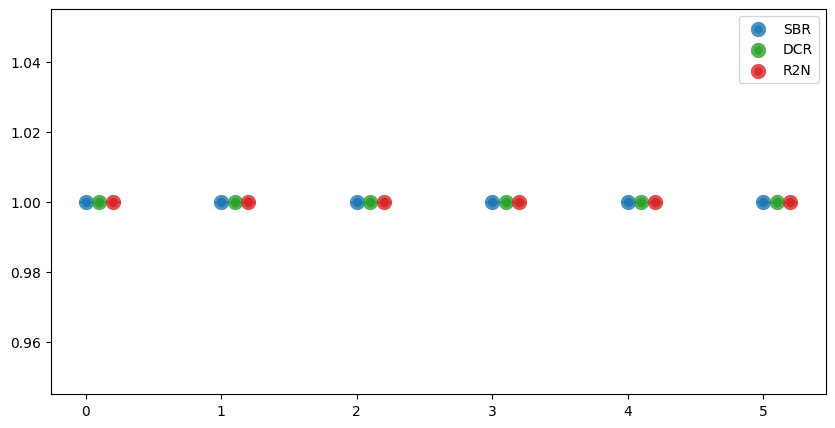

In [47]:
# select the times new roman font
plt.rcParams['font.family'] = 'Times New Roman'
root_dir = "C:\\Users\\rodri\\Downloads\\PhD\\Review_grounders\\keras_ns_grounders\\experiments\\countries\\hparamsearch\\figures\\"
for metric in metrics:
    for task in tasks:
        for KGE in KGEs:
            for rule_miner in rule_miners:
                print('KGE: ', KGE, ' Metric: ', metric, ' Task: ', task, ' Rule miner: ', rule_miner)
                if rule_miner not in dfs[task][KGE][metric].keys():
                    continue
                subset_models = [i for i in models_no_baseline if i in list(dfs[task][KGE][metric][rule_miner]['mean'].keys())]
                df_mean = dfs[task][KGE][metric][rule_miner]['mean'][subset_models]                    
                df_std = dfs[task][KGE][metric][rule_miner]['std'][subset_models]
                try:
                    df_mean_baseline = dfs[task][KGE][metric][rule_miner]['mean'][baseline_model].mean()
                    baseline_found = True
                except:
                    baseline_found = False
                # df_std_baseline = dfs[task][KGE][metric][rule_miner]['std'][baseline_model]
                # Remove no reasoner and include a line where it is written baseline
                plt.figure(figsize=(10,5))
                for i,model in enumerate(df_mean.columns):
                    color = model_colors[model]
                    try:
                        plt.scatter(np.arange(len(df_mean.index))+0.1*i, df_mean[model], label=models_name[model], alpha=.8,linewidth=5,color=color) 
                        plt.errorbar(np.arange(len(df_mean.index))+0.1*i, df_mean[model], yerr=df_std[model], fmt='o',capsize=5, alpha=.7,linewidth=2,color=color)
                    except:
                        continue
                plt.legend()
                labels = [ground_name[i] for i in df_mean.index]
                plt.xticks(np.arange(len(df_mean.index))+0.2, labels, rotation=0, fontsize=18)
                if 'time' in metric:
                    plt.ylabel(metric_names[metric], fontsize=18)
                else:
                    plt.ylabel(metric_names[metric]+' on '+step+' set', fontsize=18)
                plt.xlabel('Grounder', fontsize=18)
                min = np.array([i for i in dfs[task][KGE][metric][rule_miner]['mean'].values.ravel() if not np.isnan(i)])  
                max = np.array([i for i in dfs[task][KGE][metric][rule_miner]['mean'].values.ravel() if not np.isnan(i)]) 

                if min.min()<1: #max.max()<=.9:
                    plt.ylim(min.min()-0.1,max.max()+0.1)
                # elif max.max()>=.9:
                #     plt.ylim(min.min()-0.1,1.01)
                if metric == step+'_task_mrr' and baseline_found:
                    print('Best result: ',max.max(), 'Baseline: ', np.round(df_mean_baseline,3))
                    plt.axhline(y=df_mean_baseline, color='black', linestyle='--', alpha=.7)  # Change color and linestyle as desired
                    plt.text(1.8, df_mean_baseline-0.009, 'Baseline', color='black', fontsize=15, ha='right',clip_on=True)
                    plt.text(0.05, 0.05, 'Best result: '+str(np.round(max.max(),3))+'       Baseline, KGE Complex: '+str(np.round(df_mean_baseline,3)), transform=plt.gca().transAxes,
                            fontsize=15, verticalalignment='bottom', horizontalalignment='left')
                plt.title(f'Results for the dataset {dataset_names[task]}', fontsize=18)
                # plt.title(f'Dataset: {dataset_names[task]}, KGE: {KGE}, Set: {step}, Rule miner: {rule_miner}')
                plt.show()
                # SAVE THE FIGURE
                # if the directory does not exist, create it
                # os.makedirs(root_dir) if not os.path.exists(root_dir) else None
                # plt.savefig(root_dir+'Grounders_across_models__'+'Task_'+task+'_Metric_'+metric+'_KGE_'+KGE+'_rule_'+rule_miner+'.png', dpi=300, bbox_inches='tight')  

In [9]:
# tables for overleaf
for task in dfs.keys():
    for KGE in dfs[task].keys():
        for metric in dfs[task][KGE].keys():
            for rule_miner in dfs[task][KGE][metric].keys():
                try:
                    print('Task: ', task, 'KGE: ', KGE, ' Metric: ', metric, ' Rule miner: ', rule_miner)
                    print(dfs[task][KGE][metric][rule_miner]['mean'])
                    print('latex code:')
                    print(dfs[task][KGE][metric][rule_miner]['mean'].to_latex())
                    # show the table in pd instead of series
                    print(dfs[task][KGE][metric][rule_miner][['mean']])
                except:
                    continue

Task:  countries_s2 KGE:  complex  Metric:  test_task_mrr  Rule miner:  No
model_name    dcr  no_reasoner    r2n    sbr
grounder                                    
backward_1_1  1.0        0.997  1.000  0.997
backward_1_2  1.0          NaN  1.000  0.997
backward_1_3  1.0          NaN  1.000  0.997
backward_2_1  1.0          NaN  1.000  0.997
backward_2_2  1.0          NaN  0.998  0.997
backward_2_3  1.0          NaN  0.998  0.997
latex code:
\begin{tabular}{lrrrr}
\toprule
model_name & dcr & no_reasoner & r2n & sbr \\
grounder &  &  &  &  \\
\midrule
backward_1_1 & 1.000000 & 0.997000 & 1.000000 & 0.997000 \\
backward_1_2 & 1.000000 & NaN & 1.000000 & 0.997000 \\
backward_1_3 & 1.000000 & NaN & 1.000000 & 0.997000 \\
backward_2_1 & 1.000000 & NaN & 1.000000 & 0.997000 \\
backward_2_2 & 1.000000 & NaN & 0.998000 & 0.997000 \\
backward_2_3 & 1.000000 & NaN & 0.998000 & 0.997000 \\
\bottomrule
\end{tabular}

Task:  countries_s2 KGE:  complex  Metric:  time_train  Rule miner:  No
model_na

In [10]:
d = dfs['countries_s1']['complex']['test_task_mrr']['No']['mean'].copy()
d = d[models]
# Substitute by the proper names 
d.columns = [models_name[i] for i in d.columns]
d.index = [ground_name[i] for i in d.index]
# drop the column of the baseline in backward 1
baseline = d['Baseline'].loc['Backward 1']
d


KeyError: 'mean'

# Create the table for the overleaf by models

In [7]:
rows = 'grounder'
cols = ['test_task_mrr', 'test_task_hits@1@1','test_task_hits@3@3', 'test_task_hits@10@10','time_train','time_inference']
models_results = []
best_results = nested_dict(3, dict)
for model in models_no_baseline:
    df_table = None
    # for task in ['countries_s1','countries_s2','countries_s3','nations','kinship_family','pharmkg_small']:#tasks:
    for task in ['pharmkg_full','wn18rr', 'FB15k237' ]:
        for KGE in KGEs:
            for rule_miner in rule_miners:                # verify that the rule miner is within the values of Rule_Miner, else continue
                miners_available = df.loc[ (df['dataset_name'] == task) &(df['kge'] == KGE)]['rule_miner'].apply(lambda x: str(x)).unique()
                if (rule_miner not in miners_available):
                    continue
                print('\nModel',model,' Task: ', task, 'KGE: ', KGE, ' Metric: ', metric,  ' Rule miner: ', rule_miner)
                # filter the df
                results = df.loc[(df['model_name'] == model) & (df['dataset_name'] == task) &(df['kge'] == KGE) &(df['rule_miner'] == rule_miner) & df['grounder'].isin(grounders)].copy() #& (df['WeightLoss_Task'] == 0.5) & (df['Reasoner_depth'] == 1) & (df['EmbedSize'] == 100)].copy()
                # take only the columns grounder, model, test_task_mrr, test_concept_mrr
                results = results[['dataset_name',rows]+cols]
                # get the results of the baseline
                baseline = df.loc[(df['model_name'] == 'no_reasoner') & (df['dataset_name'] == task) &(df['kge'] == KGE) &(df['rule_miner'] == rule_miner) &(df['grounder'] == 'backward_1') ][['grounder']+cols]
                # print(baseline)
                # add the baseline to the list
                # if the baseline is empty, append '-'
                if len(baseline) == 0:
                    list_to_append  = [task,'Baseline'] + ['-']*(len(cols))
                else:
                    list_to_append  = [task] + list(baseline.values[0])
                    list_to_append[list_to_append.index('backward_1')] = 'Baseline'
                results = results.reset_index(drop=True)
                results.loc[len(results)] = list_to_append
                print('\nresults',results) 
                # for the colums ['test_task_mrr', 'test_task_hits@1@1','test_task_hits@3@3', 'test_task_hits@10@10'], get the best result, which is in the first element of the list of each cell
                for col in ['test_task_mrr', 'test_task_hits@1@1','test_task_hits@3@3', 'test_task_hits@10@10']:
                    # best_results[task][col] = results[col].apply(lambda x: x[0] if type(x) is np.ndarray else x).max()
                    results_ = results[col].apply(lambda x: x[0] if type(x) is np.ndarray else x)
                    best_results[model][task][col]  =  results_[results_.apply(lambda x: type(x) is not str)].max()
                    print('\nbest_results',col,best_results[model][task][col])
                results = results.reset_index(drop=True)
                if df_table is None:
                    df_table = results
                else:
                    df_table = pd.concat([df_table, results], ignore_index=True)
    # add the model to the list
    models_results.append(df_table)


NameError: name 'metric' is not defined

In [40]:
def bold_best_result_col(x, best_results,model, task, col):
    if type(x) is np.ndarray:
        mean_original,var_original = x
        if 'time' in col:
            mean,var = round(mean_original,1),round(var_original,1)
        else:
            mean,var = round(100*mean_original,1),round(100*var_original,1)
        # print('mean_original',mean_original, task,col,best_results[model][task][col])
        if mean_original == best_results[model][task][col]:
            return '\\textbf{'+str(mean)+'}±'+str(var)
        else:
            return str(mean)+'±'+str(var)
    else:
        return x
    

for i,df_table in enumerate(models_results):
    # convert the content of every cell in cols from '[n1,n2]' to str(n1)+'+'+str(n2) if the content is not a string
    for col in cols:
        # df_table[col] = df_table[col].apply(lambda x: str(x[0])+'±'+str(x[1]) if type(x) is np.ndarray else x)
        df_table[col] = df_table.apply(lambda x: bold_best_result_col(x[col], best_results,models_no_baseline[i], x['dataset_name'], col), axis=1)
    

    # substitute the names of the colums by the proper names. For column, if its name is in metric_names, substitute it by the value of the dictionary
    list_cols = ['Dataset', 'Grounder'] + [metric_names[i] if i in metric_names.keys() else i for i in cols]
    df_table.columns = list_cols

    # in df_table, subtitute in the column Dataset the names of the datasets by the proper names, and do the same for the grounders
    df_table['Dataset'] = df_table['Dataset'].apply(lambda x: dataset_names[x])
    df_table['Grounder'] = df_table['Grounder'].apply(lambda x: ground_name[x] if x in ground_name.keys() else x)
    df_table = df_table.reset_index(drop=True)

In [41]:
# show the full df in the print
pd.set_option('display.max_rows', None) 
models_results[2]

,Dataset,Grounder,MRR,Hits@1,Hits@3,Hits@10,Train Time (s),Inference Time (s)
0,PharmKG,Backward 1,\textbf{54.0}±0.0,\textbf{51.7}±0.0,\textbf{53.7}±0.0,\textbf{58.4}±0.0,1481.7±0.0,17379.3±0.0
1,PharmKG,Baseline,53.2±0.0,51.6±0.0,53.1±0.0,56.0±0.0,216.9±0.0,1996.8±0.0
2,WN18RR,Backward 1,51.8±0.0,51.2±0.0,52.1±0.0,52.5±0.0,204.7±0.0,3666.0±0.0
3,WN18RR,Backward 2,\textbf{58.8}±0.0,\textbf{55.5}±0.0,\textbf{60.9}±0.0,\textbf{65.5}±0.0,2354.4±0.0,15575.7±0.0
4,WN18RR,Baseline,50.8±0.0,50.5±0.0,50.9±0.0,51.3±0.0,46.9±0.0,1084.3±0.0


In [45]:
number = 2
print(models_no_baseline[number])
print(models_results[number].to_latex(index=False))

r2n
\begin{tabular}{llllllll}
\toprule
Dataset & Grounder & MRR & Hits@1 & Hits@3 & Hits@10 & Train Time (s) & Inference Time (s) \\
\midrule
PharmKG & Backward 1 & \textbf{54.0}±0.0 & \textbf{51.7}±0.0 & \textbf{53.7}±0.0 & \textbf{58.4}±0.0 & 1481.7±0.0 & 17379.3±0.0 \\
PharmKG & Baseline & 53.2±0.0 & 51.6±0.0 & 53.1±0.0 & 56.0±0.0 & 216.9±0.0 & 1996.8±0.0 \\
WN18RR & Backward 1 & 51.8±0.0 & 51.2±0.0 & 52.1±0.0 & 52.5±0.0 & 204.7±0.0 & 3666.0±0.0 \\
WN18RR & Backward 2 & \textbf{58.8}±0.0 & \textbf{55.5}±0.0 & \textbf{60.9}±0.0 & \textbf{65.5}±0.0 & 2354.4±0.0 & 15575.7±0.0 \\
WN18RR & Baseline & 50.8±0.0 & 50.5±0.0 & 50.9±0.0 & 51.3±0.0 & 46.9±0.0 & 1084.3±0.0 \\
\bottomrule
\end{tabular}

